Readmission Prediction 
*Jie Che*

Introduction

Readmissions to hospitals place a significant burden on care resources, and on patients' health. The interval between readmission is therefore a significant indicator of the performance of healthcare. 

Task

Your task is to use the MIMIC-IV dataset to develop a model/pipeline to predict whether or not a patient is likely to be readmitted within:

1. 30 days

2. 60 days

3. 90 days

If you develop/use more than one model, report the relevant scores for all of them. 

Report which features are most useful for predicting readmission. 

Ideally upload a jupyter file with your code and documentation. DO NOT upload the data, but create a placeholder for the data in the same folder as your code. Kindly do not use blankspaces in the datafile name, and do not include any hard coded paths in your code. 

Further Instructions/Tips:

1. You can find a number of pre-processing pipelines for this dataset as code, and open sourced. If you use any of them, please mention that you are using those. However, be careful about how these pipelines select/discard features. Using these will prevent you from understanding the data well. The choice is yours. 

2. For this particular assignment, and because the dataset is complex, you can choose to ignore some parts/features of the dataset, for instance any timeseries information pertaining to instrument measurements (BP for eg). If you do so, please report that. 

Readmission is the 0/1 classification.

Part I  Read the data and determine what are the possible factors that could affect Readmission status. 

Examples of such factors may include:
age, sex, days in(hospital, emergency, icu), diagnosis(icd), blood and microbiology test, pharmacy, etc,.
Firstly see what we can read from the data.


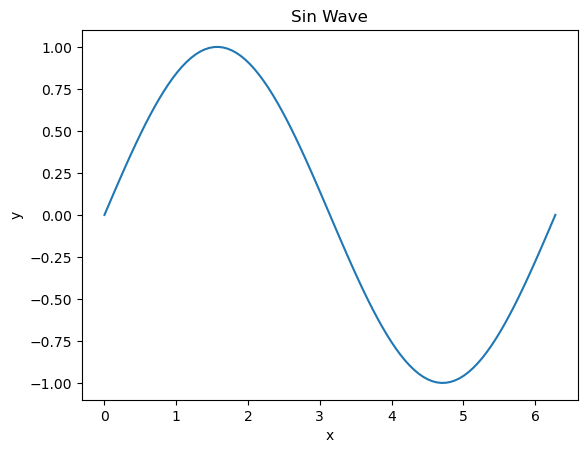

In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# test
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

# draw 
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sin Wave')
plt.show()


In [80]:
#import the data
#Admission
mimic_path='/Users/jieche/Desktop/machine learning/mimic-iv-2.2/'

admits = pd.read_csv(mimic_path + 'hosp/admissions.csv.gz', compression='gzip')
admits.head()



,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [4]:
admits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431231 entries, 0 to 431230
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            431231 non-null  int64 
 1   hadm_id               431231 non-null  int64 
 2   admittime             431231 non-null  object
 3   dischtime             431231 non-null  object
 4   deathtime             8598 non-null    object
 5   admission_type        431231 non-null  object
 6   admit_provider_id     431227 non-null  object
 7   admission_location    431231 non-null  object
 8   discharge_location    312076 non-null  object
 9   insurance             431231 non-null  object
 10  language              431231 non-null  object
 11  marital_status        421998 non-null  object
 12  race                  431231 non-null  object
 13  edregtime             299282 non-null  object
 14  edouttime             299282 non-null  object
 15  hospital_expire_f

In [81]:
#fill the deathtime with boolean
admits['died_in_hosp'] = admits['deathtime'].notnull().map({True: 1, False: 0})
admits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431231 entries, 0 to 431230
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            431231 non-null  int64 
 1   hadm_id               431231 non-null  int64 
 2   admittime             431231 non-null  object
 3   dischtime             431231 non-null  object
 4   deathtime             8598 non-null    object
 5   admission_type        431231 non-null  object
 6   admit_provider_id     431227 non-null  object
 7   admission_location    431231 non-null  object
 8   discharge_location    312076 non-null  object
 9   insurance             431231 non-null  object
 10  language              431231 non-null  object
 11  marital_status        421998 non-null  object
 12  race                  431231 non-null  object
 13  edregtime             299282 non-null  object
 14  edouttime             299282 non-null  object
 15  hospital_expire_f

In [82]:
null_counts_adm = admits.isnull().sum()
print(null_counts_adm)

subject_id                   0
hadm_id                      0
admittime                    0
dischtime                    0
deathtime               422633
admission_type               0
admit_provider_id            4
admission_location           0
discharge_location      119155
insurance                    0
language                     0
marital_status            9233
race                         0
edregtime               131949
edouttime               131949
hospital_expire_flag         0
died_in_hosp                 0
dtype: int64


In [83]:
#patient
patients = pd.read_csv(mimic_path + 'hosp/patients.csv.gz', compression='gzip')
patients.head()


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


In [13]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299712 entries, 0 to 299711
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         299712 non-null  int64 
 1   gender             299712 non-null  object
 2   anchor_age         299712 non-null  int64 
 3   anchor_year        299712 non-null  int64 
 4   anchor_year_group  299712 non-null  object
 5   dod                29076 non-null   object
dtypes: int64(3), object(3)
memory usage: 13.7+ MB


In [16]:

null_counts_patients = patients.isnull().sum()
print(null_counts_patients)

subject_id                0
gender                    0
anchor_age                0
anchor_year               0
anchor_year_group         0
dod                  270636
dtype: int64


In [84]:
#merge patients and admisssions(according to the description, subject id is the identification of patients, while hadm id is the event number, here use the subject id)
admits_patients = pd.merge(admits, patients, how='inner', on='subject_id')
admits_patients.head()


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,race,edregtime,edouttime,hospital_expire_flag,died_in_hosp,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,0,F,52,2180,2014 - 2016,2180-09-09
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0,0,F,52,2180,2014 - 2016,2180-09-09
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0,0,F,52,2180,2014 - 2016,2180-09-09
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,...,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0,0,F,52,2180,2014 - 2016,2180-09-09
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,...,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0,0,F,19,2160,2008 - 2010,NaN


In [85]:
admits_patients['race'].value_counts()


WHITE                                        272932
BLACK/AFRICAN AMERICAN                        59959
OTHER                                         15102
UNKNOWN                                       10668
HISPANIC/LATINO - PUERTO RICAN                 8076
WHITE - OTHER EUROPEAN                         7925
HISPANIC OR LATINO                             7754
ASIAN                                          6156
ASIAN - CHINESE                                5587
WHITE - RUSSIAN                                5024
BLACK/CAPE VERDEAN                             4765
HISPANIC/LATINO - DOMINICAN                    4383
BLACK/CARIBBEAN ISLAND                         2704
BLACK/AFRICAN                                  2530
PATIENT DECLINED TO ANSWER                     1761
UNABLE TO OBTAIN                               1603
PORTUGUESE                                     1510
ASIAN - SOUTH EAST ASIAN                       1446
HISPANIC/LATINO - GUATEMALAN                   1330
ASIAN - ASIA

Too many branches, low it down

In [86]:
import re

# 将所有以"white"开头的字符串替换为"white"
admits_patients['race'] = admits_patients['race'].apply(lambda x: re.sub(r'^WHITE.*', 'WHITE',str(x)))
admits_patients['race'] = admits_patients['race'].apply(lambda x: re.sub(r'^BLACK.*', 'BLACK', str(x)))
admits_patients['race'] = admits_patients['race'].apply(lambda x: re.sub(r'^ASIAN.*', 'ASIAN', str(x)))
admits_patients['race'] = admits_patients['race'].apply(lambda x: re.sub(r'^HISPANIC.*', 'HISPANIC',str(x)))
admits_patients['race'].value_counts()


WHITE                                        288154
BLACK                                         69958
HISPANIC                                      25212
OTHER                                         15102
ASIAN                                         14893
UNKNOWN                                       10668
PATIENT DECLINED TO ANSWER                     1761
UNABLE TO OBTAIN                               1603
PORTUGUESE                                     1510
AMERICAN INDIAN/ALASKA NATIVE                   919
MULTIPLE RACE/ETHNICITY                         560
SOUTH AMERICAN                                  505
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER       386
Name: race, dtype: int64

In [87]:
#put the others in the same category: other/unknown
admits_patients['race'].loc[~admits_patients['race'].isin(admits_patients['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
admits_patients['race'].value_counts()

/var/folders/ck/8r_z2td51y379bxk8krf4ss00000gn/T/ipykernel_22780/2792575538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admits_patients['race'].loc[~admits_patients['race'].isin(admits_patients['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'


WHITE            288154
BLACK             69958
HISPANIC          25212
OTHER/UNKNOWN     17912
OTHER             15102
ASIAN             14893
Name: race, dtype: int64

In [88]:
#combine other and other/unknown
admits_patients['race'].replace(['OTHER/UNKNOWN', 'OTHER'], value='OTHER/UNKNOWN', inplace=True)
admits_patients['race'].value_counts()


WHITE            288154
BLACK             69958
OTHER/UNKNOWN     33014
HISPANIC          25212
ASIAN             14893
Name: race, dtype: int64

In [89]:
# calculate the admission type (here I use the code from:https://github.com/nicolaDeCristofaro/Predictive_Models_in_Healthcare/blob/master/01_data_exploration_preparation.ipynb)
admits_patients['admission_type'].value_counts()


EW EMER.                       149413
EU OBSERVATION                  94776
OBSERVATION ADMIT               52668
URGENT                          44691
SURGICAL SAME DAY ADMISSION     34231
DIRECT EMER.                    19554
DIRECT OBSERVATION              18707
ELECTIVE                        10565
AMBULATORY OBSERVATION           6626
Name: admission_type, dtype: int64

In [90]:
#put emer, urgent, dierct emer together, put eu observation, observation admit, direct observation, ambulatory observation together
admits_patients['admission_type'].replace(to_replace='EW EMER.', value='EMERGENCY', inplace=True)
admits_patients['admission_type'].replace(to_replace='DIRECT EMER.', value='EMERGENCY', inplace=True)
admits_patients['admission_type'].replace(to_replace='URGENT', value='EMERGENCY', inplace=True)
admits_patients['admission_type'].replace(to_replace='EU OBSERVATION', value='OBSERVATION', inplace=True)
admits_patients['admission_type'].replace(to_replace='OBSERVATION ADMIT', value='OBSERVATION', inplace=True)
admits_patients['admission_type'].replace(to_replace='DIRECT OBSERVATION', value='OBSERVATION', inplace=True)
admits_patients['admission_type'].replace(to_replace='AMBULATORY OBSERVATION', value='OBSERVATION', inplace=True)
admits_patients['admission_type'].value_counts()



EMERGENCY                      213658
OBSERVATION                    172777
SURGICAL SAME DAY ADMISSION     34231
ELECTIVE                        10565
Name: admission_type, dtype: int64

In [91]:
admits_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431231 entries, 0 to 431230
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            431231 non-null  int64 
 1   hadm_id               431231 non-null  int64 
 2   admittime             431231 non-null  object
 3   dischtime             431231 non-null  object
 4   deathtime             8598 non-null    object
 5   admission_type        431231 non-null  object
 6   admit_provider_id     431227 non-null  object
 7   admission_location    431231 non-null  object
 8   discharge_location    312076 non-null  object
 9   insurance             431231 non-null  object
 10  language              431231 non-null  object
 11  marital_status        421998 non-null  object
 12  race                  431231 non-null  object
 13  edregtime             299282 non-null  object
 14  edouttime             299282 non-null  object
 15  hospital_expire_f

In [92]:
admits_patients = admits_patients[['subject_id','hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'race', 'died_in_hosp','gender','anchor_age']]
admits_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431231 entries, 0 to 431230
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   subject_id      431231 non-null  int64 
 1   hadm_id         431231 non-null  int64 
 2   admittime       431231 non-null  object
 3   dischtime       431231 non-null  object
 4   deathtime       8598 non-null    object
 5   admission_type  431231 non-null  object
 6   race            431231 non-null  object
 7   died_in_hosp    431231 non-null  int64 
 8   gender          431231 non-null  object
 9   anchor_age      431231 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 36.2+ MB


In [16]:
admits_patients.loc[admits_patients.subject_id == 10002155, ['subject_id', 'admittime', 'admission_type']]


,subject_id,admittime,admission_type
102,10002155,2131-03-09 20:33:00,EMERGENCY
103,10002155,2129-08-04 12:44:00,EMERGENCY
104,10002155,2128-07-29 17:01:00,EMERGENCY
105,10002155,2129-12-24 01:36:00,EMERGENCY
106,10002155,2130-09-23 21:59:00,EMERGENCY


In [17]:
# read diagnoses_icd table
icds = pd.read_csv(mimic_path + 'hosp/diagnoses_icd.csv.gz', compression='gzip')

icds.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


There are icd 9 and icd 10, two different classification of diagnosis

In [29]:
icds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
dtypes: int64(4), object(1)
memory usage: 181.4+ MB


In [30]:
icds.icd_version.value_counts()


9     2766877
10    1989449
Name: icd_version, dtype: int64

In [5]:
icds.iloc[:, 3]


0           5723
1          78959
2           5715
3          07070
4            496
           ...  
4756321    41401
4756322    78039
4756323     0413
4756324    36846
4756325     7810
Name: icd_code, Length: 4756326, dtype: object

In [9]:
#transfer from icd10 to icd9, here it takes a long time (~6h), I store the result in another file so that I don't need to do that each time
import pandas as pd
import csv


def icd10_to_icd9(icd10):
    with open('ICD_9_10_d_v1.1.csv', newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row[0] == icd10:
                return row[1]
    return ''



df = pd.read_csv(mimic_path + 'hosp/diagnoses_icd.csv.gz',compression='gzip', header=None)

# use loc to choose all icd=10 ,and transfer it to icd9
icd10_mask = df.loc[:, 4] == '10'
df.loc[icd10_mask, 3] = df.loc[icd10_mask, 2].apply(icd10_to_icd9)


df.head()

/var/folders/ck/8r_z2td51y379bxk8krf4ss00000gn/T/ipykernel_17292/677486938.py:19: DtypeWarning: Columns (0,1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(mimic_path + 'hosp/diagnoses_icd.csv.gz',compression='gzip', header=None)


,0,1,2,3,4
0,subject_id,hadm_id,seq_num,icd_code,icd_version
1,10000032,22595853,1,5723,9
2,10000032,22595853,2,78959,9
3,10000032,22595853,3,5715,9
4,10000032,22595853,4,07070,9


In [18]:
#Here I didn't run again, so there is the alarm
df.to_csv('diag_icds_transfer.csv', index=False)




NameError: name 'df' is not defined

In [19]:
diag_icds = pd.read_csv('diag_icds_transfer.csv')

diag_icds.columns = diag_icds.iloc[0]
diag_icds = diag_icds.iloc[1:].reset_index(drop=True)

diag_icds.head()


/var/folders/ck/8r_z2td51y379bxk8krf4ss00000gn/T/ipykernel_22780/2406960701.py:1: DtypeWarning: Columns (0,1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  diag_icds = pd.read_csv('diag_icds_transfer.csv')


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [22]:
diag_icds.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  object
dtypes: int64(3), object(2)
memory usage: 181.4+ MB


In [23]:
#even the code is stored as object, change the datatype to int64
diag_icds['subject_id'] = diag_icds['subject_id'].astype('int64')
diag_icds['hadm_id'] = diag_icds['hadm_id'].astype('int64')
diag_icds['seq_num'] = diag_icds['seq_num'].astype('int64')
diag_icds.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  object
dtypes: int64(3), object(2)
memory usage: 181.4+ MB


In [25]:
print(diag_icds['subject_id'].iloc[:1])


0    10000032
Name: subject_id, dtype: int64


In [26]:
diag_icds.loc[diag_icds.subject_id == 10000032, ['subject_id', 'icd_code']]


,subject_id,icd_code
0,10000032,5723
1,10000032,78959
2,10000032,5715
3,10000032,07070
4,10000032,496
5,10000032,29680
6,10000032,30981
7,10000032,V1582
8,10000032,07071
9,10000032,78959


In [27]:
diag_icds.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


Here I use the method from: https://github.com/nicolaDeCristofaro/Predictive_Models_in_Healthcare/blob/master/01_data_exploration_preparation.ipynb
From ICD-9 codes supercategories: https://en.wikipedia.org/wiki/List_of_ICD-9_codes
To simplify the code, I use the supercategory, which only take the first 3 codes into consideration.

In [28]:
# Filter out E and V codes from ICD9 codes since processing will be done on the numeric first 3 values
diag_icds['recode'] = diag_icds['icd_code']
diag_icds['recode'] = diag_icds['recode'][~diag_icds['recode'].str.contains("[a-zA-Z]").fillna(False)]
diag_icds['recode'].fillna(value='999', inplace=True)

# Take in consideration just the first 3 integers of the ICD9 code
diag_icds['recode'] = diag_icds['recode'].str.slice(start=0, stop=3, step=1)
diag_icds['recode'] = diag_icds['recode'].astype(int)
diag_icds.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version,recode
0,10000032,22595853,1,5723,9,572
1,10000032,22595853,2,78959,9,789
2,10000032,22595853,3,5715,9,571
3,10000032,22595853,4,07070,9,70
4,10000032,22595853,5,496,9,496


In [29]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580,
                                                    630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    diag_icds['recode'] = np.where(diag_icds['recode'].between(
        cat_range[0], cat_range[1]), num, diag_icds['recode'])

# Convert integer to category name using diag_dict
diag_icds['super_category'] = diag_icds['recode'].replace(diag_dict)
diag_icds.head()


,subject_id,hadm_id,seq_num,icd_code,icd_version,recode,super_category
0,10000032,22595853,1,5723,9,8,digestive
1,10000032,22595853,2,78959,9,15,misc
2,10000032,22595853,3,5715,9,8,digestive
3,10000032,22595853,4,07070,9,0,infectious
4,10000032,22595853,5,496,9,7,respiratory


In [38]:
diag_icds.loc[diag_icds.subject_id ==10000032, ['subject_id', 'recode']]


,subject_id,recode
0,10000032,8
1,10000032,15
2,10000032,8
3,10000032,0
4,10000032,7
5,10000032,4
6,10000032,4
7,10000032,16
8,10000032,0
9,10000032,15


For each admission, there could be more than one diagnosis, and list them with hadm_id:

In [39]:
# Create list of diagnoses for each admission
hadm_list = diag_icds.groupby('hadm_id')['super_category'].apply(list).reset_index()
hadm_list.head()


,hadm_id,super_category
0,20000019,"[infectious, genitourinary, congenital, genito..."
1,20000024,"[injury, injury, injury, injury, injury, injur..."
2,20000034,"[injury, injury, injury, injury, injury, injur..."
3,20000041,"[muscular, endocrine, injury, circulatory, end..."
4,20000057,"[muscular, muscular, injury, injury, injury, r..."


In [40]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['super_category'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()


/var/folders/ck/8r_z2td51y379bxk8krf4ss00000gn/T/ipykernel_22780/4058680188.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  hadm_item = pd.get_dummies(hadm_list['super_category'].apply(pd.Series).stack()).sum(level=0)


,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,1,1,1,0,3,2,1,2,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0
3,0,1,0,1,3,0,0,4,0,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,7,0,1,5,0,4,0,1,2,0


In [41]:
# Join back with HADM_ID
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")


In [93]:
# Merge with main dataframe
admits_patients_diag = pd.merge(admits_patients, hadm_item, how='inner', on='hadm_id')
admits_patients_diag.head()


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,race,died_in_hosp,gender,anchor_age,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,EMERGENCY,WHITE,0,F,52,...,1,2,1,0,0,0,0,0,1,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EMERGENCY,WHITE,0,F,52,...,1,1,1,0,0,0,0,0,1,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EMERGENCY,WHITE,0,F,52,...,2,1,2,0,0,0,0,0,1,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EMERGENCY,WHITE,0,F,52,...,3,2,2,0,0,0,0,0,1,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,OBSERVATION,WHITE,0,F,19,...,0,1,0,0,0,0,0,0,0,0


In [94]:
admits_patients_diag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430852 entries, 0 to 430851
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   subject_id      430852 non-null  int64 
 1   hadm_id         430852 non-null  int64 
 2   admittime       430852 non-null  object
 3   dischtime       430852 non-null  object
 4   deathtime       8575 non-null    object
 5   admission_type  430852 non-null  object
 6   race            430852 non-null  object
 7   died_in_hosp    430852 non-null  int64 
 8   gender          430852 non-null  object
 9   anchor_age      430852 non-null  int64 
 10  blood           430852 non-null  uint8 
 11  circulatory     430852 non-null  uint8 
 12  congenital      430852 non-null  uint8 
 13  digestive       430852 non-null  uint8 
 14  endocrine       430852 non-null  uint8 
 15  genitourinary   430852 non-null  uint8 
 16  infectious      430852 non-null  uint8 
 17  injury          430852 non-nu

In [95]:
print(admits_patients_diag.admittime.isnull().sum())
# Drop null values

print(admits_patients_diag.dischtime.isnull().sum())


0
0


In [96]:
admits_patients_diag.admission_type.value_counts()


EMERGENCY                      213436
OBSERVATION                    172675
SURGICAL SAME DAY ADMISSION     34184
ELECTIVE                        10557
Name: admission_type, dtype: int64

I think the elective patients are those under plan, who don't belong to the model I want to predict. Find these patients and filter their data.

In [97]:
# Firstly find these patients
elective_groups = admits_patients_diag.groupby('subject_id')['admission_type'].apply(lambda x: any(x.str.contains('ELECTIVE')))

# 获取包含 "elective" 记录的 "subject_id"
elective_subject_ids = elective_groups[elective_groups].index.tolist()


In [98]:
# filter the subject_id including elective
filtered_data = admits_patients_diag[~admits_patients_diag['subject_id'].isin(elective_subject_ids)]


In [99]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389070 entries, 0 to 430851
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   subject_id      389070 non-null  int64 
 1   hadm_id         389070 non-null  int64 
 2   admittime       389070 non-null  object
 3   dischtime       389070 non-null  object
 4   deathtime       8031 non-null    object
 5   admission_type  389070 non-null  object
 6   race            389070 non-null  object
 7   died_in_hosp    389070 non-null  int64 
 8   gender          389070 non-null  object
 9   anchor_age      389070 non-null  int64 
 10  blood           389070 non-null  uint8 
 11  circulatory     389070 non-null  uint8 
 12  congenital      389070 non-null  uint8 
 13  digestive       389070 non-null  uint8 
 14  endocrine       389070 non-null  uint8 
 15  genitourinary   389070 non-null  uint8 
 16  infectious      389070 non-null  uint8 
 17  injury          389070 non-nu

In [98]:
filtered_data.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,race,died_in_hosp,gender,anchor_age,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,EMERGENCY,WHITE,0,F,52,...,1,2,1,0,0,0,0,0,1,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EMERGENCY,WHITE,0,F,52,...,1,1,1,0,0,0,0,0,1,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EMERGENCY,WHITE,0,F,52,...,2,1,2,0,0,0,0,0,1,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EMERGENCY,WHITE,0,F,52,...,3,2,2,0,0,0,0,0,1,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,OBSERVATION,WHITE,0,F,19,...,0,1,0,0,0,0,0,0,0,0


In [100]:
filtered_data.admission_type.value_counts()


EMERGENCY                      196131
OBSERVATION                    161625
SURGICAL SAME DAY ADMISSION     31314
Name: admission_type, dtype: int64

In [101]:
random_rows = filtered_data.sample(n=5)

print(random_rows)


        subject_id   hadm_id            admittime            dischtime  \
367176    18523318  26886676  2137-02-01 16:39:00  2137-02-02 05:54:00   
258498    15996479  24609064  2137-01-10 16:06:00  2137-01-15 13:00:00   
389500    19023983  29775567  2122-11-04 05:50:00  2122-11-08 12:40:00   
289320    16723173  24161916  2152-07-22 11:15:00  2152-07-24 14:34:00   
419718    19741526  29462710  2127-03-26 21:53:00  2127-03-28 11:25:00   

       deathtime admission_type   race  died_in_hosp gender  anchor_age  ...  \
367176       NaN    OBSERVATION  WHITE             0      M          45  ...   
258498       NaN    OBSERVATION  BLACK             0      F          39  ...   
389500       NaN      EMERGENCY  WHITE             0      F          38  ...   
289320       NaN      EMERGENCY  WHITE             0      F          63  ...   
419718       NaN      EMERGENCY  WHITE             0      F          32  ...   

        injury  mental  misc  muscular  neoplasms  nervous  pregnancy  \
3

In [102]:
#calculate the readmission date, first group the data by admittime

sort_admits_patients_diag = filtered_data.sort_values(['subject_id', 'admittime'])
sort_admits_patients_diag.head()



,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,race,died_in_hosp,gender,anchor_age,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,EMERGENCY,WHITE,0,F,52,...,1,2,1,0,0,0,0,0,1,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EMERGENCY,WHITE,0,F,52,...,1,1,1,0,0,0,0,0,1,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EMERGENCY,WHITE,0,F,52,...,3,2,2,0,0,0,0,0,1,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EMERGENCY,WHITE,0,F,52,...,2,1,2,0,0,0,0,0,1,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,OBSERVATION,WHITE,0,F,19,...,0,1,0,0,0,0,0,0,0,0


In [104]:
sort_admits_patients_diag.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389070 entries, 0 to 430851
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   subject_id      389070 non-null  int64 
 1   hadm_id         389070 non-null  int64 
 2   admittime       389070 non-null  object
 3   dischtime       389070 non-null  object
 4   deathtime       8031 non-null    object
 5   admission_type  389070 non-null  object
 6   race            389070 non-null  object
 7   died_in_hosp    389070 non-null  int64 
 8   gender          389070 non-null  object
 9   anchor_age      389070 non-null  int64 
 10  blood           389070 non-null  uint8 
 11  circulatory     389070 non-null  uint8 
 12  congenital      389070 non-null  uint8 
 13  digestive       389070 non-null  uint8 
 14  endocrine       389070 non-null  uint8 
 15  genitourinary   389070 non-null  uint8 
 16  infectious      389070 non-null  uint8 
 17  injury          389070 non-nu

In [104]:
sort_admits_patients_diag.loc[sort_admits_patients_diag.subject_id == 10000032,['subject_id','admittime','admission_type']]

,subject_id,admittime,admission_type
0,10000032,2180-05-06 22:23:00,EMERGENCY
1,10000032,2180-06-26 18:27:00,EMERGENCY
3,10000032,2180-07-23 12:35:00,EMERGENCY
2,10000032,2180-08-05 23:44:00,EMERGENCY


In [105]:
#check the filtered patient(find one patient with elective)
sort_admits_patients_diag.loc[sort_admits_patients_diag.subject_id == 10002167,['subject_id','admittime','admission_type']]

,subject_id,admittime,admission_type


In [106]:
# add the next admission date for each subject using groupby and shift function
sort_admits_patients_diag['next_admittime'] = sort_admits_patients_diag.groupby('subject_id').admittime.shift(-1)
sort_admits_patients_diag.loc[sort_admits_patients_diag.subject_id == 10000032,['subject_id','admittime','admission_type','next_admittime']]

,subject_id,admittime,admission_type,next_admittime
0,10000032,2180-05-06 22:23:00,EMERGENCY,2180-06-26 18:27:00
1,10000032,2180-06-26 18:27:00,EMERGENCY,2180-07-23 12:35:00
3,10000032,2180-07-23 12:35:00,EMERGENCY,2180-08-05 23:44:00
2,10000032,2180-08-05 23:44:00,EMERGENCY,NaN


In [107]:
#change the datatype
# convert dates
sort_admits_patients_diag.admittime = pd.to_datetime(sort_admits_patients_diag.admittime)
sort_admits_patients_diag.dischtime = pd.to_datetime(sort_admits_patients_diag.dischtime)
sort_admits_patients_diag.next_admittime = pd.to_datetime(sort_admits_patients_diag.next_admittime)


In [111]:
sort_admits_patients_diag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389070 entries, 0 to 430851
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   subject_id      389070 non-null  int64         
 1   hadm_id         389070 non-null  int64         
 2   admittime       389070 non-null  datetime64[ns]
 3   dischtime       389070 non-null  datetime64[ns]
 4   deathtime       8031 non-null    object        
 5   admission_type  389070 non-null  object        
 6   race            389070 non-null  object        
 7   died_in_hosp    389070 non-null  int64         
 8   gender          389070 non-null  object        
 9   anchor_age      389070 non-null  int64         
 10  blood           389070 non-null  uint8         
 11  circulatory     389070 non-null  uint8         
 12  congenital      389070 non-null  uint8         
 13  digestive       389070 non-null  uint8         
 14  endocrine       389070 non-null  uin

In [108]:
# calculate the number of days between discharge and next admission
sort_admits_patients_diag['days_next_admit'] = (sort_admits_patients_diag.next_admittime - sort_admits_patients_diag.dischtime).dt.total_seconds()/(24*60*60)


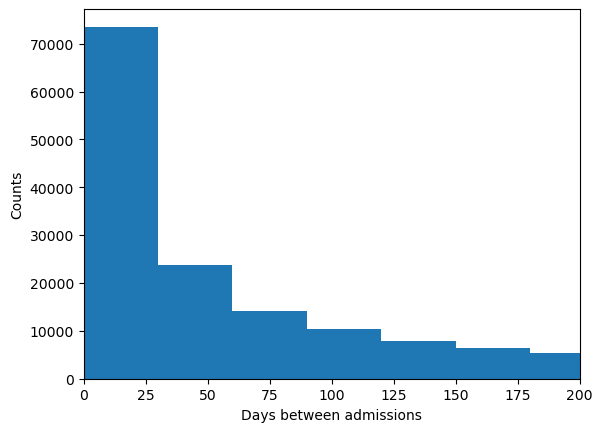

In [109]:
# plot a histogram of days between readmissions if they exist
plt.hist(sort_admits_patients_diag.loc[~sort_admits_patients_diag.days_next_admit.isnull(), 'days_next_admit'], bins=range(0, 365, 30))
plt.xlim([0, 200])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()


In [110]:
sort_admits_patients_diag.anchor_age.value_counts()


91    11674
57     7575
60     7453
62     7441
64     7432
      ...  
87     3545
88     3174
19     2909
89     2062
18     1767
Name: anchor_age, Length: 73, dtype: int64

In [111]:
#to lower down the dimension of ages, I sort it into several categories
age_ranges = [(0, 13), (14, 36), (37, 56), (57, 100)]
for num, cat_range in enumerate(age_ranges):
    sort_admits_patients_diag['anchor_age'] = np.where(sort_admits_patients_diag['anchor_age'].between(cat_range[0], cat_range[1]), num, sort_admits_patients_diag['anchor_age'])

age_dict = {0: 'NEWBORN', 1: 'YOUNG_ADULT', 2: 'MIDDLE_ADULT', 3: 'SENIOR'}
sort_admits_patients_diag['anchor_age'] = sort_admits_patients_diag['anchor_age'].replace(age_dict)
sort_admits_patients_diag.anchor_age.value_counts()


SENIOR          204057
MIDDLE_ADULT    110533
YOUNG_ADULT      74480
Name: anchor_age, dtype: int64

In [112]:
sort_admits_patients_diag.died_in_hosp.value_counts()


0    381039
1      8031
Name: died_in_hosp, dtype: int64

In [113]:
#filter out the died patients
sort_admits_patients_diag = sort_admits_patients_diag.loc[sort_admits_patients_diag['died_in_hosp'] == 0]
sort_admits_patients_diag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381039 entries, 0 to 430851
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   subject_id       381039 non-null  int64         
 1   hadm_id          381039 non-null  int64         
 2   admittime        381039 non-null  datetime64[ns]
 3   dischtime        381039 non-null  datetime64[ns]
 4   deathtime        0 non-null       object        
 5   admission_type   381039 non-null  object        
 6   race             381039 non-null  object        
 7   died_in_hosp     381039 non-null  int64         
 8   gender           381039 non-null  object        
 9   anchor_age       381039 non-null  object        
 10  blood            381039 non-null  uint8         
 11  circulatory      381039 non-null  uint8         
 12  congenital       381039 non-null  uint8         
 13  digestive        381039 non-null  uint8         
 14  endocrine        381

In [114]:
sort_admits_patients_diag = sort_admits_patients_diag.drop('deathtime', axis=1)
sort_admits_patients_diag = sort_admits_patients_diag.drop('died_in_hosp', axis=1)
sort_admits_patients_diag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381039 entries, 0 to 430851
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   subject_id       381039 non-null  int64         
 1   hadm_id          381039 non-null  int64         
 2   admittime        381039 non-null  datetime64[ns]
 3   dischtime        381039 non-null  datetime64[ns]
 4   admission_type   381039 non-null  object        
 5   race             381039 non-null  object        
 6   gender           381039 non-null  object        
 7   anchor_age       381039 non-null  object        
 8   blood            381039 non-null  uint8         
 9   circulatory      381039 non-null  uint8         
 10  congenital       381039 non-null  uint8         
 11  digestive        381039 non-null  uint8         
 12  endocrine        381039 non-null  uint8         
 13  genitourinary    381039 non-null  uint8         
 14  infectious       381

In [61]:
#import icu data
icudata= pd.read_csv(mimic_path + 'icu/icustays.csv.gz', compression='gzip')
icudata.head()


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [123]:
icudata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73181 entries, 0 to 73180
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      73181 non-null  int64  
 1   hadm_id         73181 non-null  int64  
 2   stay_id         73181 non-null  int64  
 3   first_careunit  73181 non-null  object 
 4   last_careunit   73181 non-null  object 
 5   intime          73181 non-null  object 
 6   outtime         73181 non-null  object 
 7   los             73181 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 4.5+ MB


In [62]:
null_counts_icu = icudata.isnull().sum()
print(null_counts_icu)


subject_id        0
hadm_id           0
stay_id           0
first_careunit    0
last_careunit     0
intime            0
outtime           0
los               0
dtype: int64


Here I only use the data of first_careunit

In [125]:
icudata.first_careunit.value_counts()



Medical Intensive Care Unit (MICU)                  15898
Medical/Surgical Intensive Care Unit (MICU/SICU)    12733
Cardiac Vascular Intensive Care Unit (CVICU)        11582
Surgical Intensive Care Unit (SICU)                 11161
Trauma SICU (TSICU)                                  8692
Coronary Care Unit (CCU)                             8311
Neuro Intermediate                                   2035
Neuro Surgical Intensive Care Unit (Neuro SICU)      1762
Neuro Stepdown                                       1007
Name: first_careunit, dtype: int64

In [63]:
icudata['category'] = icudata['first_careunit']
icu_list = icudata.groupby('hadm_id')['category'].apply(list).reset_index()
icu_list.head()


,hadm_id,category
0,20000094,[Coronary Care Unit (CCU)]
1,20000147,[Coronary Care Unit (CCU)]
2,20000351,[Medical/Surgical Intensive Care Unit (MICU/SI...
3,20000808,"[Surgical Intensive Care Unit (SICU), Surgical..."
4,20001305,[Medical/Surgical Intensive Care Unit (MICU/SI...


In [64]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['category'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['hadm_id'], how="outer")
icu_item.head()


/var/folders/ck/8r_z2td51y379bxk8krf4ss00000gn/T/ipykernel_22780/2432110415.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  icu_item = pd.get_dummies(icu_list['category'].apply(pd.Series).stack()).sum(level=0)


,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU),hadm_id
0,0,1,0,0,0,0,0,0,0,20000094
1,0,1,0,0,0,0,0,0,0,20000147
2,0,0,0,1,0,0,0,0,0,20000351
3,0,0,0,0,0,0,0,1,0,20000808
4,0,0,0,1,0,0,0,0,0,20001305


In [115]:
# Merge ICU data with main dataFrame
final_df = sort_admits_patients_diag.merge(icu_item, how='outer', on='hadm_id')
final_df.head()


,subject_id,hadm_id,admittime,dischtime,admission_type,race,gender,anchor_age,blood,circulatory,...,days_next_admit,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,10000032.0,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,EMERGENCY,WHITE,F,MIDDLE_ADULT,0.0,0.0,...,50.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000032.0,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,EMERGENCY,WHITE,F,MIDDLE_ADULT,1.0,0.0,...,25.740278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000032.0,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,EMERGENCY,WHITE,F,MIDDLE_ADULT,0.0,1.0,...,11.242361,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10000032.0,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,EMERGENCY,WHITE,F,MIDDLE_ADULT,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000068.0,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,OBSERVATION,WHITE,F,YOUNG_ADULT,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393844 entries, 0 to 393843
Data columns (total 36 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   subject_id                                        381039 non-null  float64       
 1   hadm_id                                           393844 non-null  int64         
 2   admittime                                         381039 non-null  datetime64[ns]
 3   dischtime                                         381039 non-null  datetime64[ns]
 4   admission_type                                    381039 non-null  object        
 5   race                                              381039 non-null  object        
 6   gender                                            381039 non-null  object        
 7   anchor_age                                        381039 non-null  object        
 8   blood         

In [117]:
final_df.head()

,subject_id,hadm_id,admittime,dischtime,admission_type,race,gender,anchor_age,blood,circulatory,...,days_next_admit,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,10000032.0,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,EMERGENCY,WHITE,F,MIDDLE_ADULT,0.0,0.0,...,50.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000032.0,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,EMERGENCY,WHITE,F,MIDDLE_ADULT,1.0,0.0,...,25.740278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000032.0,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,EMERGENCY,WHITE,F,MIDDLE_ADULT,0.0,1.0,...,11.242361,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10000032.0,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,EMERGENCY,WHITE,F,MIDDLE_ADULT,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000068.0,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,OBSERVATION,WHITE,F,YOUNG_ADULT,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
#drop the useless columns
final_df.drop(columns=[ 'subject_id', 'hadm_id', 'admittime', 'dischtime'], inplace=True)

final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393844 entries, 0 to 393843
Data columns (total 32 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   admission_type                                    381039 non-null  object        
 1   race                                              381039 non-null  object        
 2   gender                                            381039 non-null  object        
 3   anchor_age                                        381039 non-null  object        
 4   blood                                             381039 non-null  float64       
 5   circulatory                                       381039 non-null  float64       
 6   congenital                                        381039 non-null  float64       
 7   digestive                                         381039 non-null  float64       
 8   endocrine     

In [119]:
final_df.head()


,admission_type,race,gender,anchor_age,blood,circulatory,congenital,digestive,endocrine,genitourinary,...,days_next_admit,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,EMERGENCY,WHITE,F,MIDDLE_ADULT,0.0,0.0,0.0,2.0,0.0,0.0,...,50.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EMERGENCY,WHITE,F,MIDDLE_ADULT,1.0,0.0,0.0,1.0,1.0,0.0,...,25.740278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EMERGENCY,WHITE,F,MIDDLE_ADULT,0.0,1.0,0.0,1.0,2.0,0.0,...,11.242361,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EMERGENCY,WHITE,F,MIDDLE_ADULT,0.0,0.0,0.0,1.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OBSERVATION,WHITE,F,YOUNG_ADULT,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
final_df.gender.value_counts()


F    201455
M    179584
Name: gender, dtype: int64

In [121]:
# change gender attribute to boolean 
final_df['gender'].replace({'M': 0, 'F': 1}, inplace=True)



In [122]:
final_df.gender.value_counts()


1.0    201455
0.0    179584
Name: gender, dtype: int64

In [123]:
#change admission type, race, age to dummy variables
prefix_cols = ['ADM', 'RAC', 'AGE']
dummy_cols = ['admission_type', 'race', 'anchor_age']
final_df = pd.get_dummies(final_df, prefix=prefix_cols, columns=dummy_cols)
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393844 entries, 0 to 393843
Data columns (total 40 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   gender                                            381039 non-null  float64       
 1   blood                                             381039 non-null  float64       
 2   circulatory                                       381039 non-null  float64       
 3   congenital                                        381039 non-null  float64       
 4   digestive                                         381039 non-null  float64       
 5   endocrine                                         381039 non-null  float64       
 6   genitourinary                                     381039 non-null  float64       
 7   infectious                                        381039 non-null  float64       
 8   injury        

In [124]:
final_df.isnull().sum()


gender                                               12805
blood                                                12805
circulatory                                          12805
congenital                                           12805
digestive                                            12805
endocrine                                            12805
genitourinary                                        12805
infectious                                           12805
injury                                               12805
mental                                               12805
misc                                                 12805
muscular                                             12805
neoplasms                                            12805
nervous                                              12805
pregnancy                                            12805
prenatal                                             12805
respiratory                                          128

In [125]:
final_df_without_nan = final_df.dropna(subset=['gender'])


In [126]:
final_df_without_nan.isnull().sum()


gender                                                   0
blood                                                    0
circulatory                                              0
congenital                                               0
digestive                                                0
endocrine                                                0
genitourinary                                            0
infectious                                               0
injury                                                   0
mental                                                   0
misc                                                     0
muscular                                                 0
neoplasms                                                0
nervous                                                  0
pregnancy                                                0
prenatal                                                 0
respiratory                                             

In [127]:
#filter out the patients who don't have next admission
final_df_without_nan = final_df_without_nan.dropna(subset=['next_admittime'])


In [128]:
final_df_without_nan.isnull().sum()


gender                                                   0
blood                                                    0
circulatory                                              0
congenital                                               0
digestive                                                0
endocrine                                                0
genitourinary                                            0
infectious                                               0
injury                                                   0
mental                                                   0
misc                                                     0
muscular                                                 0
neoplasms                                                0
nervous                                                  0
pregnancy                                                0
prenatal                                                 0
respiratory                                             

In [129]:
final_df_without_nan.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 216346 entries, 0 to 381037
Data columns (total 40 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   gender                                            216346 non-null  float64       
 1   blood                                             216346 non-null  float64       
 2   circulatory                                       216346 non-null  float64       
 3   congenital                                        216346 non-null  float64       
 4   digestive                                         216346 non-null  float64       
 5   endocrine                                         216346 non-null  float64       
 6   genitourinary                                     216346 non-null  float64       
 7   infectious                                        216346 non-null  float64       
 8   injury        

Open the full output data, and the remained attribute that contain null value belong to icu data, fill the null value with 0

In [130]:
final = final_df_without_nan.fillna(0)


In [131]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216346 entries, 0 to 381037
Data columns (total 40 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   gender                                            216346 non-null  float64       
 1   blood                                             216346 non-null  float64       
 2   circulatory                                       216346 non-null  float64       
 3   congenital                                        216346 non-null  float64       
 4   digestive                                         216346 non-null  float64       
 5   endocrine                                         216346 non-null  float64       
 6   genitourinary                                     216346 non-null  float64       
 7   infectious                                        216346 non-null  float64       
 8   injury        

In [132]:
final.isnull().sum()

gender                                              0
blood                                               0
circulatory                                         0
congenital                                          0
digestive                                           0
endocrine                                           0
genitourinary                                       0
infectious                                          0
injury                                              0
mental                                              0
misc                                                0
muscular                                            0
neoplasms                                           0
nervous                                             0
pregnancy                                           0
prenatal                                            0
respiratory                                         0
skin                                                0
next_admittime              

In [133]:
final.head()

,gender,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,ADM_OBSERVATION,ADM_SURGICAL SAME DAY ADMISSION,RAC_ASIAN,RAC_BLACK,RAC_HISPANIC,RAC_OTHER/UNKNOWN,RAC_WHITE,AGE_MIDDLE_ADULT,AGE_SENIOR,AGE_YOUNG_ADULT
0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,...,0,0,0,0,0,0,1,1,0,0
1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,1,1,0,0
2,1.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,3.0,2.0,...,0,0,0,0,0,0,1,1,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0,0,0,0,0,0,1,0,1,0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,1,0,0,0,0,0,1,1,0,0


Finish data preprocessing, find out the output labels

In [134]:
final['READMISSION_30'] = (final.days_next_admit < 30).astype('int')
final['READMISSION_60'] = (final.days_next_admit < 60).astype('int')
final['READMISSION_90'] = (final.days_next_admit < 90).astype('int')


In [135]:
print('Number of patients readmitted within 30 days:', (final.READMISSION_30 == 1).sum())
print('Number of patients readmitted above 30 days:',  (final.READMISSION_30 == 0).sum())
print('Total:', len(final))


Number of patients readmitted within 30 days: 73552
Number of patients readmitted above 30 days: 142794
Total: 216346


In [136]:
print('Number of patients readmitted within 60 days:',(final.READMISSION_60 == 1).sum())
print('Number of patients readmitted above 60 days:',(final.READMISSION_60 == 0).sum())
print('Total:', len(final))


Number of patients readmitted within 60 days: 97348
Number of patients readmitted above 60 days: 118998
Total: 216346


In [137]:
print('Number of patients readmitted within 90 days:',(final.READMISSION_90 == 1).sum())
print('Number of patients readmitted above 30 days:',(final.READMISSION_90 == 0).sum())
print('Total:', len(final))


Number of patients readmitted within 90 days: 111504
Number of patients readmitted above 30 days: 104842
Total: 216346


In [138]:
final.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 216346 entries, 0 to 381037
Data columns (total 43 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   gender                                            216346 non-null  float64       
 1   blood                                             216346 non-null  float64       
 2   circulatory                                       216346 non-null  float64       
 3   congenital                                        216346 non-null  float64       
 4   digestive                                         216346 non-null  float64       
 5   endocrine                                         216346 non-null  float64       
 6   genitourinary                                     216346 non-null  float64       
 7   infectious                                        216346 non-null  float64       
 8   injury        

In [139]:
final.drop(columns=['next_admittime', 'days_next_admit'], inplace=True)



In [140]:
final.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 216346 entries, 0 to 381037
Data columns (total 41 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   gender                                            216346 non-null  float64
 1   blood                                             216346 non-null  float64
 2   circulatory                                       216346 non-null  float64
 3   congenital                                        216346 non-null  float64
 4   digestive                                         216346 non-null  float64
 5   endocrine                                         216346 non-null  float64
 6   genitourinary                                     216346 non-null  float64
 7   infectious                                        216346 non-null  float64
 8   injury                                            216346 non-null  float64
 9   ment

In [144]:
final.head()

,gender,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,RAC_BLACK,RAC_HISPANIC,RAC_OTHER/UNKNOWN,RAC_WHITE,AGE_MIDDLE_ADULT,AGE_SENIOR,AGE_YOUNG_ADULT,READMISSION_30,READMISSION_60,READMISSION_90
0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,...,0,0,0,1,1,0,0,0,1,1
1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0,0,0,1,1,0,0,1,1,1
2,1.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,3.0,2.0,...,0,0,0,1,1,0,0,1,1,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0,0,0,1,0,1,0,0,1,1
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0,0,0,1,1,0,0,0,0,0


In [148]:
final_cleaned=final.astype(int)

In [149]:
final_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 216346 entries, 0 to 381037
Data columns (total 41 columns):
 #   Column                                            Non-Null Count   Dtype
---  ------                                            --------------   -----
 0   gender                                            216346 non-null  int64
 1   blood                                             216346 non-null  int64
 2   circulatory                                       216346 non-null  int64
 3   congenital                                        216346 non-null  int64
 4   digestive                                         216346 non-null  int64
 5   endocrine                                         216346 non-null  int64
 6   genitourinary                                     216346 non-null  int64
 7   infectious                                        216346 non-null  int64
 8   injury                                            216346 non-null  int64
 9   mental                    

In [153]:
#store final as dsv
final_cleaned.to_csv('final_data.dsv', sep='\t', index=False)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
df=pd.read_csv('final_data.dsv', sep='\t')
df.head()

,gender,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,RAC_BLACK,RAC_HISPANIC,RAC_OTHER/UNKNOWN,RAC_WHITE,AGE_MIDDLE_ADULT,AGE_SENIOR,AGE_YOUNG_ADULT,READMISSION_30,READMISSION_60,READMISSION_90
0,1,0,0,0,2,0,0,1,1,2,...,0,0,0,1,1,0,0,0,1,1
1,1,1,0,0,1,1,0,1,1,1,...,0,0,0,1,1,0,0,1,1,1
2,1,0,1,0,1,2,0,1,3,2,...,0,0,0,1,1,0,0,1,1,1
3,0,0,0,0,0,0,0,0,6,0,...,0,0,0,1,0,1,0,0,1,1
4,1,0,0,0,0,0,0,0,9,0,...,0,0,0,1,1,0,0,0,0,0


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216346 entries, 0 to 216345
Data columns (total 41 columns):
 #   Column                                            Non-Null Count   Dtype
---  ------                                            --------------   -----
 0   gender                                            216346 non-null  int64
 1   blood                                             216346 non-null  int64
 2   circulatory                                       216346 non-null  int64
 3   congenital                                        216346 non-null  int64
 4   digestive                                         216346 non-null  int64
 5   endocrine                                         216346 non-null  int64
 6   genitourinary                                     216346 non-null  int64
 7   infectious                                        216346 non-null  int64
 8   injury                                            216346 non-null  int64
 9   mental                    

Prediction Model

Here I applied supervised model, because we have the label(30,60,90 readmission), and we want to predict what the input is.

I will begin with spit the model to train and test sets as 80:20

In [6]:
final_cleaned =pd.read_csv('final_data.dsv', sep='\t')

In [7]:
READMISSION_30 = final_cleaned['READMISSION_30'].values
# Prediction Features, filter out readmission 30,60,90
features = final_cleaned.drop(columns=['READMISSION_30', 'READMISSION_60', 'READMISSION_90'])


In [8]:
feature_names=features.columns.tolist()


In [9]:
print (feature_names)

['gender', 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary', 'infectious', 'injury', 'mental', 'misc', 'muscular', 'neoplasms', 'nervous', 'pregnancy', 'prenatal', 'respiratory', 'skin', 'Cardiac Vascular Intensive Care Unit (CVICU)', 'Coronary Care Unit (CCU)', 'Medical Intensive Care Unit (MICU)', 'Medical/Surgical Intensive Care Unit (MICU/SICU)', 'Neuro Intermediate', 'Neuro Stepdown', 'Neuro Surgical Intensive Care Unit (Neuro SICU)', 'Surgical Intensive Care Unit (SICU)', 'Trauma SICU (TSICU)', 'ADM_EMERGENCY', 'ADM_OBSERVATION', 'ADM_SURGICAL SAME DAY ADMISSION', 'RAC_ASIAN', 'RAC_BLACK', 'RAC_HISPANIC', 'RAC_OTHER/UNKNOWN', 'RAC_WHITE', 'AGE_MIDDLE_ADULT', 'AGE_SENIOR', 'AGE_YOUNG_ADULT']


In [10]:
from sklearn.model_selection import train_test_split

# Split into training set 80% and test set 20%
X_train, X_test, y_train, y_test = train_test_split(features,READMISSION_30,test_size=0.2,random_state=0)

# The distribution between train and test data set
print("Train: {}".format(X_train.shape[0]))
print("Test: {}".format(X_test.shape[0]))


Train: 173076
Test: 43270


I will try random forest first

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# construct rf classifier
rf = RandomForestClassifier()

# apply rf
rf.fit(X_train, y_train)

# predict with rf
y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

# calculate accuracy


print("Accuracy on training set: {}".format(accuracy_score(y_train, y_train_pred)))

accuracy = accuracy_score(y_test, y_test_pred)

print("Random Forest accuracy：", accuracy)


Accuracy on training set: 0.8744251080450207
Random Forest accuracy： 0.6548416917032586


Calculate the performance of rf: accuracy, recall, auc

In [14]:
from sklearn.metrics import classification_report

# 计算分类指标
report_test = classification_report(y_test, y_test_pred)

print("Report for test set: ", report_test)

report_train = classification_report(y_train, y_train_pred)

print("Report for train set: ", report_train)


Report for test set:                precision    recall  f1-score   support

           0       0.69      0.88      0.77     28590
           1       0.48      0.21      0.30     14680

    accuracy                           0.65     43270
   macro avg       0.58      0.55      0.53     43270
weighted avg       0.62      0.65      0.61     43270

Report for train set:                precision    recall  f1-score   support

           0       0.87      0.96      0.91    114204
           1       0.90      0.71      0.79     58872

    accuracy                           0.87    173076
   macro avg       0.88      0.84      0.85    173076
weighted avg       0.88      0.87      0.87    173076



In [16]:
# predict probabilities on test set
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



y_test_proba = rf.predict_proba(X_test)[:, 1]
y_train_proba = rf.predict_proba(X_train)[:, 1]

# calculate AUC score
auc_test = roc_auc_score(y_test, y_test_proba)
auc_train = roc_auc_score(y_train, y_train_proba)
print('Train AUC:%.3f' % auc_train)
print('Test AUC:%.3f' % auc_test)


Train AUC:0.951
Test AUC:0.607


In [17]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)


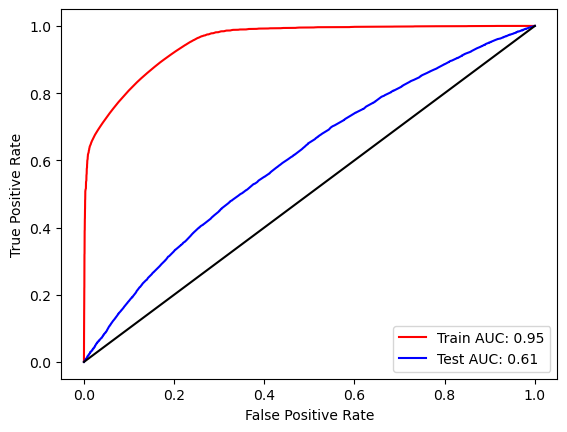

In [18]:
plt.plot(fpr_train, tpr_train, 'r-', label='Train AUC: %.2f' % auc_train)
plt.plot(fpr_test, tpr_test, 'b-', label='Test AUC: %.2f' % auc_test)
plt.plot([0, 1], [0, 1], '-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [19]:
#use k-fold to calculate auc
from sklearn.model_selection import cross_val_score
auc_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')

# 输出交叉验证得分的平均值和标准差
print("AUC scores: ", auc_scores)
print("Average AUC score: ", np.mean(auc_scores))
print("Standard deviation of AUC scores: ", np.std(auc_scores))



AUC scores:  [0.60959149 0.60705418 0.60230087 0.60859075 0.61190862]
Average AUC score:  0.6078891813949271
Standard deviation of AUC scores:  0.003208500985219631


Improve the performance of random forest

Find the most powerful references

In [31]:

from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


# Create a grid search object
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Best parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.6680186672233086


In [32]:
rf = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=2, min_samples_leaf=4)
rf.fit(X_train, y_train)
# predict with rf
y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

# calculate accuracy


print("Accuracy on training set: {}".format(
    accuracy_score(y_train, y_train_pred)))

accuracy = accuracy_score(y_test, y_test_pred)

print("Random Forest accuracy：", accuracy)


Accuracy on training set: 0.6885356721902517
Random Forest accuracy： 0.6703489715738387


2. SVM, the kernel is linear

In [30]:
from sklearn.svm import SVC  # "Support vector classifier"
# Set the linear kernel and a large value of C
svm_l = SVC(kernel='linear', C=1.0, random_state=42)
svm_l.fit(X_train, y_train)

# predict with rf
y_pred_svc = svm_l.predict(X_test)

# 计算预测准确率
accuracy_svm = accuracy_score(y_test, y_pred_svc)

print("SVC accuracy：", accuracy_svm)

KeyboardInterrupt: 

I failed here, it took too long(over night) to run, maybe svm is not a good choice for this project

3.XGBoost

In [33]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


In [34]:
X = features.values
y = READMISSION_30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:

from sklearn.model_selection import GridSearchCV

# Create XGBoost classifier
xgb_clf = xgb.XGBClassifier()

# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    xgb_clf, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.4f}")


KeyboardInterrupt: 

In [37]:
#This takes too long for me to handle, and I reduce them to 3 parameters
from sklearn.model_selection import GridSearchCV

# Create XGBoost classifier
xgb_clf = xgb.XGBClassifier()

# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    xgb_clf, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.4f}")


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best accuracy: 0.6668


In [38]:
xgb_clf = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)


The super references means:
上述超参数的含义如下：

learning_rate: 学习率
n_estimators: 树的数量
max_depth: 树的最大深度
min_child_weight: 子树的最小权重
gamma: 正则化参数
subsample: 样本采样比例
colsample_bytree: 特征采样比例
objective: 目标函数
nthread: 线程数
scale_pos_weight: 正负样本权重比
seed: 随机数种子

In [39]:
#train the model
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"AUC of XGBoost: {auc:.4f}")


AUC of XGBoost: 0.6400


In [42]:
y_pred_xgb = xgb_clf.predict(X_test)
print(f"Accuracy of XGBoost on test set: {accuracy_score(y_test, y_pred_xgb):.4f}")
y_train_pred_xgb = xgb_clf.predict(X_train)
print(f"Accuracy of XGBoost on train set: {accuracy_score(y_train, y_train_pred_xgb):.4f}")


Accuracy of XGBoost on test set: 0.6682
Accuracy of XGBoost on train set: 0.6740


4. Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Create a logistic regression model
lr = LogisticRegression()

# Create a grid search object
grid_search = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.6600510682047407


In [46]:
lr_clf = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"AUC of Logistic Regression: {auc:.4f}")
y_pred_lr = lr_clf.predict(X_test)
print(f"Accuracy of Logistic Regression on test set: {accuracy_score(y_test, y_pred_lr):.4f}")



AUC of Logistic Regression: 0.6081
Accuracy of Logistic Regression on test set: 0.6618


Now I tried 4 different methods: random forest, SVM, XGBoost, and logistic regression. Compared the accuracy and AUC score, random forest is a little bit better. So random forest is my final choice.

I think I can also use k-fold to compare the performance of different models, try it here:

In [81]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


In [86]:
from sklearn.model_selection import train_test_split

# Split into training set 80% and test set 20%
X_train, X_test, y_train, y_test = train_test_split(
    features, READMISSION_30, test_size=0.2, random_state=0)

# The distribution between train and test data set
print("Train: {}".format(X_train.shape[0]))
print("Test: {}".format(X_test.shape[0]))


Train: 173076
Test: 43270


In [92]:
models = []
models.append(('Random Forest', RandomForestClassifier()))
models.append(('XGBoost', XGBClassifier()))
models.append(('Logistic Regression', LogisticRegression(max_iter=1000)))


In [93]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


In [94]:
results = []
names = []
for name, model in models:
    cv_results = cross_val_score(
        model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")


Random Forest: 0.6541 (0.0023)
XGBoost: 0.6661 (0.0017)
Logistic Regression: 0.6597 (0.0015)


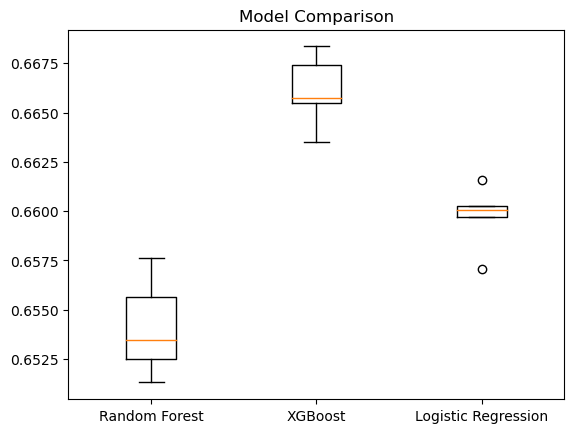

In [95]:
pyplot.boxplot(results, labels=names)
pyplot.title('Model Comparison')
pyplot.show()


In [ ]:
Analyze the performance of XGBoost


In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


In [ ]:
X = features.values
y = READMISSION_30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [98]:
xgb = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)


In [99]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"AUC of XGBoost: {auc:.4f}")


AUC of XGBoost: 0.6422


In [105]:
from sklearn.metrics import classification_report

# predict with XGBoost
y_test_pred = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train)

# 计算分类指标
report_test = classification_report(y_test, y_test_pred)

print("Report for test set: ", report_test)

report_train = classification_report(y_train, y_train_pred)

print("Report for train set: ", report_train)


Report for test set:                precision    recall  f1-score   support

           0       0.68      0.95      0.79     28590
           1       0.56      0.12      0.20     14680

    accuracy                           0.67     43270
   macro avg       0.62      0.54      0.50     43270
weighted avg       0.64      0.67      0.59     43270

Report for train set:                precision    recall  f1-score   support

           0       0.68      0.96      0.79    114204
           1       0.60      0.12      0.20     58872

    accuracy                           0.67    173076
   macro avg       0.64      0.54      0.50    173076
weighted avg       0.65      0.67      0.59    173076



In [102]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


y_test_proba = xgb.predict_proba(X_test)[:, 1]
y_train_proba = xgb.predict_proba(X_train)[:, 1]

# calculate AUC score
auc_test = roc_auc_score(y_test, y_test_proba)
auc_train = roc_auc_score(y_train, y_train_proba)
print('Train AUC:%.3f' % auc_train)
print('Test AUC:%.3f' % auc_test)


Train AUC:0.651
Test AUC:0.642


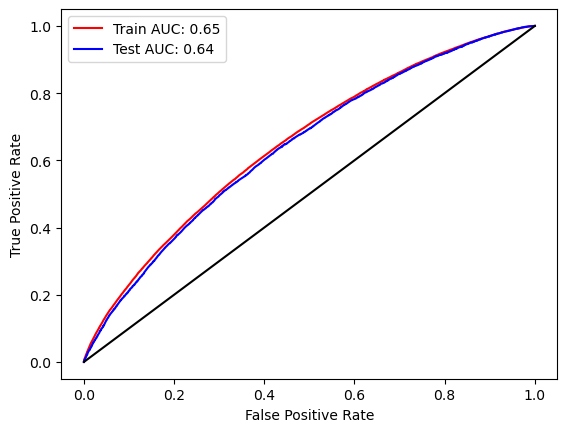

In [103]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
plt.plot(fpr_train, tpr_train, 'r-', label='Train AUC: %.2f' % auc_train)
plt.plot(fpr_test, tpr_test, 'b-', label='Test AUC: %.2f' % auc_test)
plt.plot([0, 1], [0, 1], '-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


The importance of features

In [104]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize


In [106]:
importances = xgb.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
sorted_names = [feature_names[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(f"{i+1}. {sorted_names[i]} ({importances[indices[i]]:.4f})")


Feature ranking:
1. ADM_OBSERVATION (0.0754)
2. ADM_EMERGENCY (0.0732)
3. mental (0.0678)
4. AGE_SENIOR (0.0596)
5. pregnancy (0.0557)
6. neoplasms (0.0496)
7. injury (0.0474)
8. gender (0.0393)
9. misc (0.0368)
10. AGE_YOUNG_ADULT (0.0340)
11. ADM_SURGICAL SAME DAY ADMISSION (0.0330)
12. circulatory (0.0314)
13. digestive (0.0305)
14. muscular (0.0281)
15. Trauma SICU (TSICU) (0.0235)
16. infectious (0.0223)
17. blood (0.0218)
18. Cardiac Vascular Intensive Care Unit (CVICU) (0.0206)
19. Surgical Intensive Care Unit (SICU) (0.0193)
20. endocrine (0.0185)
21. RAC_ASIAN (0.0173)
22. RAC_OTHER/UNKNOWN (0.0167)
23. genitourinary (0.0166)
24. RAC_BLACK (0.0163)
25. AGE_MIDDLE_ADULT (0.0163)
26. RAC_HISPANIC (0.0150)
27. RAC_WHITE (0.0144)
28. skin (0.0140)
29. prenatal (0.0111)
30. Coronary Care Unit (CCU) (0.0110)
31. respiratory (0.0105)
32. Medical/Surgical Intensive Care Unit (MICU/SICU) (0.0104)
33. Medical Intensive Care Unit (MICU) (0.0096)
34. congenital (0.0091)
35. nervous (0.008

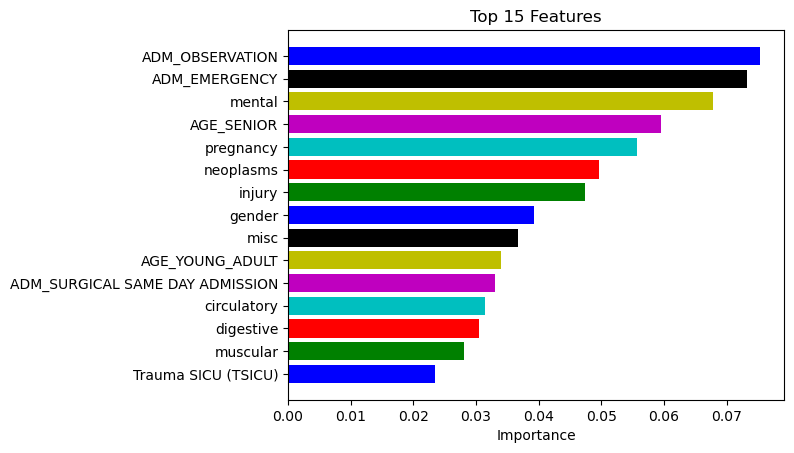

In [108]:
import matplotlib.pyplot as plt

# Select top 15 features
n_features = 15
top_features = sorted_names[:n_features][::-1]

# Create a dictionary of feature indices and importances
feature_dict = dict(zip(feature_names, importances))

# Create a list of importances for the top features
top_importances = [feature_dict[f] for f in top_features]

# Create a bar chart of the top features and their importances
plt.barh(range(len(top_features)), top_importances,
         color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])
plt.yticks(range(len(top_features)), top_features)
plt.xlabel("Importance")
plt.title("Top 15 Features")
plt.show()


Now we can see that the ADM observation and ADM emergency is the most important feature that determine the 30days readmission 

Calculate 60days readmission

In [112]:
import xgboost as xgb


In [109]:
# Target Variable READMISSION_60
READMISSION_60 = final_cleaned['READMISSION_60'].values
# Prediction Features
features = final_cleaned.drop(
    columns=['READMISSION_30', 'READMISSION_60', 'READMISSION_90'])


In [110]:
from sklearn.model_selection import train_test_split

# Split into training set 80% and test set 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    READMISSION_60,
                                                    test_size=.20,
                                                    random_state=0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 173076 samples.
Testing set has 43270 samples.


In [113]:
xgb = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)


In [114]:
from sklearn.metrics import classification_report

xgb.fit(X_train, y_train)
# predict with xgb
y_test_pred = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train)

# 计算分类指标
report_test = classification_report(y_test, y_test_pred)

print("Report for test set: ", report_test)

report_train = classification_report(y_train, y_train_pred)

print("Report for train set: ", report_train)


Report for test set:                precision    recall  f1-score   support

           0       0.63      0.74      0.68     23790
           1       0.59      0.46      0.52     19480

    accuracy                           0.61     43270
   macro avg       0.61      0.60      0.60     43270
weighted avg       0.61      0.61      0.61     43270

Report for train set:                precision    recall  f1-score   support

           0       0.63      0.74      0.68     95208
           1       0.60      0.46      0.52     77868

    accuracy                           0.62    173076
   macro avg       0.61      0.60      0.60    173076
weighted avg       0.61      0.62      0.61    173076



In [115]:
# predict probabilities on test set
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


y_test_proba = xgb.predict_proba(X_test)[:, 1]
y_train_proba = xgb.predict_proba(X_train)[:, 1]

# calculate AUC score
auc_test = roc_auc_score(y_test, y_test_proba)
auc_train = roc_auc_score(y_train, y_train_proba)
print('Train AUC:%.3f' % auc_train)
print('Test AUC:%.3f' % auc_test)


Train AUC:0.660
Test AUC:0.652


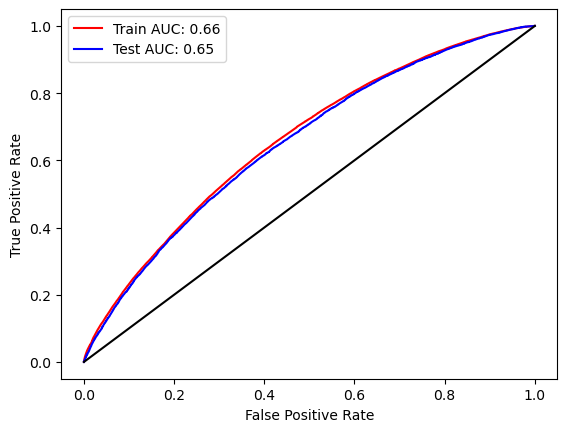

In [116]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
plt.plot(fpr_train, tpr_train, 'r-', label='Train AUC: %.2f' % auc_train)
plt.plot(fpr_test, tpr_test, 'b-', label='Test AUC: %.2f' % auc_test)
plt.plot([0, 1], [0, 1], '-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [118]:
importances = xgb.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
sorted_names = [feature_names[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(f"{i+1}. {sorted_names[i]} ({importances[indices[i]]:.4f})")


Feature ranking:
1. ADM_OBSERVATION (0.0696)
2. pregnancy (0.0665)
3. ADM_EMERGENCY (0.0655)
4. mental (0.0648)
5. ADM_SURGICAL SAME DAY ADMISSION (0.0636)
6. neoplasms (0.0619)
7. injury (0.0589)
8. AGE_SENIOR (0.0561)
9. gender (0.0378)
10. circulatory (0.0310)
11. digestive (0.0309)
12. misc (0.0306)
13. infectious (0.0293)
14. AGE_YOUNG_ADULT (0.0256)
15. blood (0.0248)
16. muscular (0.0213)
17. Surgical Intensive Care Unit (SICU) (0.0196)
18. RAC_OTHER/UNKNOWN (0.0189)
19. genitourinary (0.0177)
20. RAC_BLACK (0.0166)
21. Trauma SICU (TSICU) (0.0165)
22. endocrine (0.0164)
23. skin (0.0149)
24. RAC_HISPANIC (0.0142)
25. Cardiac Vascular Intensive Care Unit (CVICU) (0.0133)
26. RAC_WHITE (0.0127)
27. AGE_MIDDLE_ADULT (0.0101)
28. prenatal (0.0100)
29. Neuro Intermediate (0.0099)
30. respiratory (0.0099)
31. RAC_ASIAN (0.0095)
32. Medical Intensive Care Unit (MICU) (0.0087)
33. congenital (0.0083)
34. Coronary Care Unit (CCU) (0.0079)
35. nervous (0.0079)
36. Medical/Surgical Intens

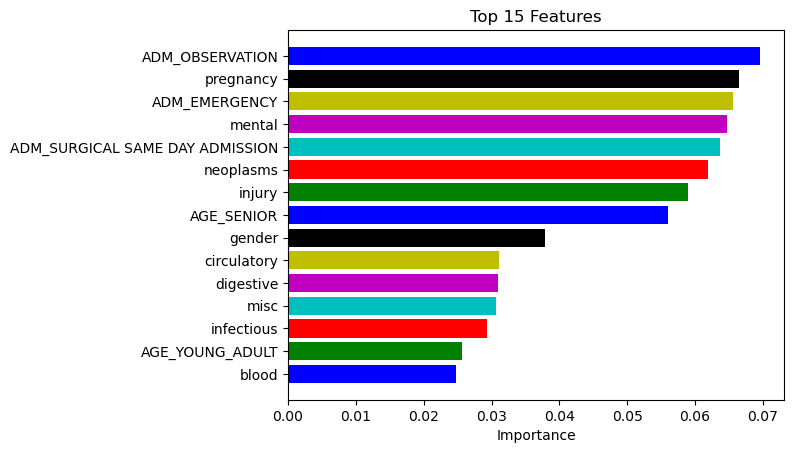

In [119]:
import matplotlib.pyplot as plt

# Select top 15 features
n_features = 15
top_features = sorted_names[:n_features][::-1]

# Create a dictionary of feature indices and importances
feature_dict = dict(zip(feature_names, importances))

# Create a list of importances for the top features
top_importances = [feature_dict[f] for f in top_features]

# Create a bar chart of the top features and their importances
plt.barh(range(len(top_features)), top_importances,
         color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])
plt.yticks(range(len(top_features)), top_features)
plt.xlabel("Importance")
plt.title("Top 15 Features")
plt.show()


The accuracy of 60days readmission seems not that good *.*
But from the features result, ADM_observation is still the most important one. But pregnancy seems more important this time.

Calculate 90days readmission

In [122]:
import xgboost as xgb

In [123]:
# Target Variable READMISSION_90
READMISSION_90 = final_cleaned['READMISSION_90'].values
# Prediction Features
features = final_cleaned.drop(columns=['READMISSION_30', 'READMISSION_60', 'READMISSION_90'])


In [121]:
from sklearn.model_selection import train_test_split

# Split into training set 80% and test set 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    READMISSION_90,
                                                    test_size=.20,
                                                    random_state=0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 173076 samples.
Testing set has 43270 samples.


In [124]:
xgb = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)


In [125]:
from sklearn.metrics import classification_report
xgb.fit(X_train, y_train)
# predict with xgb
y_test_pred = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train)

# 计算分类指标
report_test = classification_report(y_test, y_test_pred)

print("Report for test set: ", report_test)

report_train = classification_report(y_train, y_train_pred)

print("Report for train set: ", report_train)


Report for test set:                precision    recall  f1-score   support

           0       0.62      0.53      0.57     21009
           1       0.61      0.69      0.65     22261

    accuracy                           0.62     43270
   macro avg       0.62      0.61      0.61     43270
weighted avg       0.62      0.62      0.61     43270

Report for train set:                precision    recall  f1-score   support

           0       0.63      0.54      0.58     83833
           1       0.62      0.70      0.66     89243

    accuracy                           0.62    173076
   macro avg       0.62      0.62      0.62    173076
weighted avg       0.62      0.62      0.62    173076



In [126]:
# predict probabilities on test set
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


y_test_proba = xgb.predict_proba(X_test)[:, 1]
y_train_proba = xgb.predict_proba(X_train)[:, 1]

# calculate AUC score
auc_test = roc_auc_score(y_test, y_test_proba)
auc_train = roc_auc_score(y_train, y_train_proba)
print('Train AUC:%.3f' % auc_train)
print('Test AUC:%.3f' % auc_test)


Train AUC:0.669
Test AUC:0.660


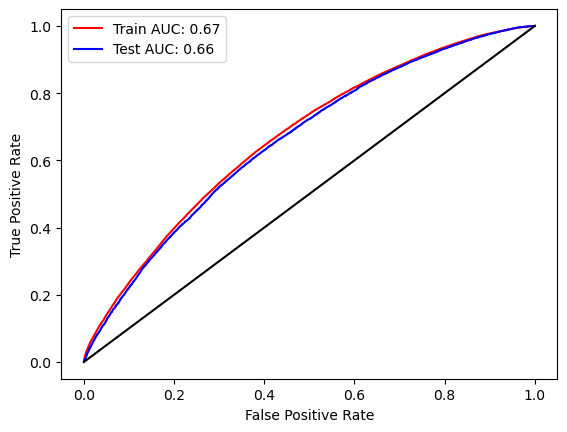

In [127]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
plt.plot(fpr_train, tpr_train, 'r-', label='Train AUC: %.2f' % auc_train)
plt.plot(fpr_test, tpr_test, 'b-', label='Test AUC: %.2f' % auc_test)
plt.plot([0, 1], [0, 1], '-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [128]:
importances = xgb.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
sorted_names = [feature_names[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(f"{i+1}. {sorted_names[i]} ({importances[indices[i]]:.4f})")


Feature ranking:
1. pregnancy (0.0906)
2. injury (0.0779)
3. ADM_EMERGENCY (0.0699)
4. mental (0.0666)
5. ADM_OBSERVATION (0.0662)
6. neoplasms (0.0645)
7. ADM_SURGICAL SAME DAY ADMISSION (0.0570)
8. AGE_SENIOR (0.0485)
9. gender (0.0335)
10. digestive (0.0305)
11. misc (0.0304)
12. circulatory (0.0290)
13. infectious (0.0263)
14. blood (0.0253)
15. genitourinary (0.0222)
16. muscular (0.0201)
17. RAC_OTHER/UNKNOWN (0.0183)
18. AGE_YOUNG_ADULT (0.0169)
19. RAC_WHITE (0.0155)
20. skin (0.0142)
21. endocrine (0.0141)
22. Neuro Intermediate (0.0140)
23. Surgical Intensive Care Unit (SICU) (0.0130)
24. RAC_BLACK (0.0125)
25. Trauma SICU (TSICU) (0.0117)
26. RAC_HISPANIC (0.0114)
27. Neuro Surgical Intensive Care Unit (Neuro SICU) (0.0103)
28. respiratory (0.0101)
29. Cardiac Vascular Intensive Care Unit (CVICU) (0.0094)
30. congenital (0.0089)
31. nervous (0.0086)
32. AGE_MIDDLE_ADULT (0.0084)
33. RAC_ASIAN (0.0082)
34. prenatal (0.0081)
35. Coronary Care Unit (CCU) (0.0080)
36. Medical/Su

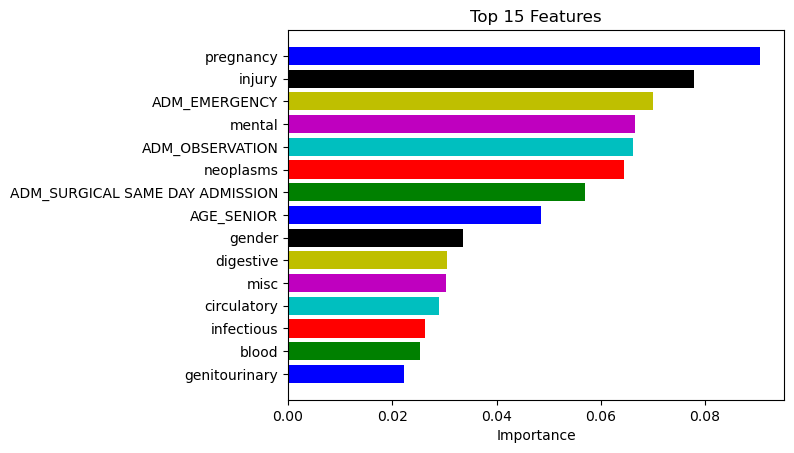

In [129]:
import matplotlib.pyplot as plt

# Select top 15 features
n_features = 15
top_features = sorted_names[:n_features][::-1]

# Create a dictionary of feature indices and importances
feature_dict = dict(zip(feature_names, importances))

# Create a list of importances for the top features
top_importances = [feature_dict[f] for f in top_features]

# Create a bar chart of the top features and their importances
plt.barh(range(len(top_features)), top_importances,
         color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])
plt.yticks(range(len(top_features)), top_features)
plt.xlabel("Importance")
plt.title("Top 15 Features")
plt.show()


For the prediction of 90 days readmission, the pregnancy is the most important feature, while injury is the second important one. That is interesting, I think pregnant women need to go back to hospital, but longer than 30 days, also injury requires going back to hospital.

Conclusion

In this project, the aim is to predict the readmission of 30, 60, 90days, I read the data from the patients, the admission, the diagnoses, and icu data. For the admission, I filter out the dead ones and the planed entry, and calculate the next admission time. For the patients, I use the race, sex, age, and reduce dimensionality. For the diagnoses, I use the chart ICD_9_10_d_v1.1 (https://github.com/AtlasCUMC/ICD10-ICD9-codes-conversion) for the transformation from icd 10 to icd9. But I also notice that the code reflection between icd9 and icd 10 may be not one to one, which means one icd10 code can refer to two or more different icd9 codes. This may lead to bias. After that, I consider the first 3 num of icd9 code, and rearrange the matrix(here thanks for https://github.com/nicolaDeCristofaro/Predictive_Models_in_Healthcare/blob/master/04_readmission.ipynb). I adopt similar steps on the icu data, merge all the data together. Then check the null value and drop the columns that I don't need.

For prediction, I tried different methods on the prediction of 30 days, including random forest, SVM, XGBoost, and logistic regression. SVM (kernel =linear) is not the appropriate one, maybe I need to use another kernel. Among random forest, XGBoost and logistic regression, XGBoost has a little better performance (if just consider accuracy). And I applied it on the prediction of 60/90 days readmission. 

Among all the features,  the most important one differs for each model. It is interesting for discussion.